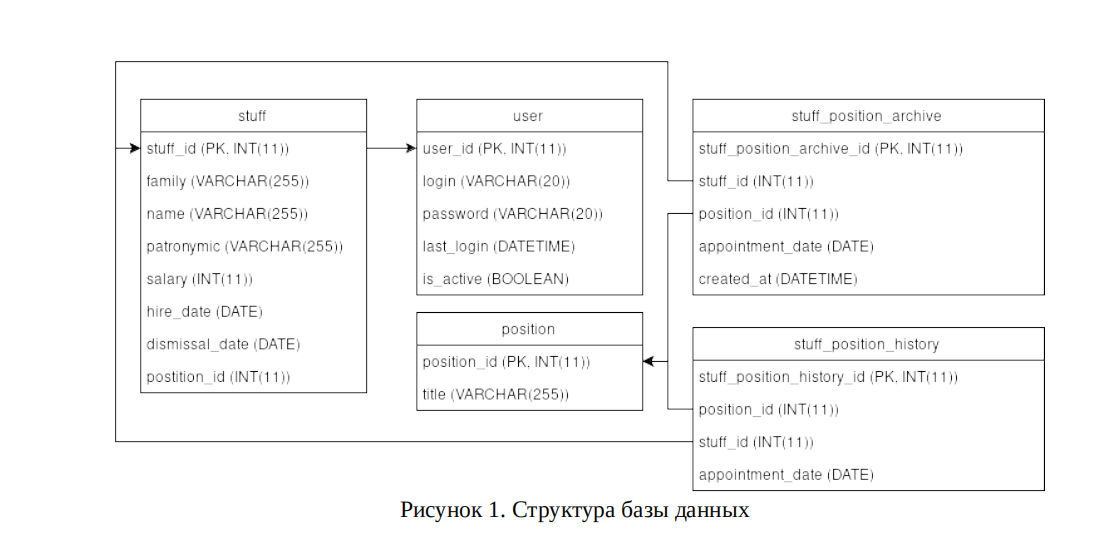

In [2]:
import mysql.connector
import pandas as pd
import random 
from faker import Faker
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from mysql.connector import connect, Error
fake = Faker('ru_RU')
r_host = "localhost"
r_user = "root"
r_password = "aryuna"
r_db = "storedprocedures"
conn = connect(
    host=r_host, 
    user=r_user,
    password=r_password,
    database = r_db,
)
cur = conn.cursor()

In [3]:
# генерация данных для хранимых процедур
stuff_num = random.randint(20, 100)
dismissed = random.sample(range(stuff_num), int(stuff_num/4)) #четверть уволена, какой кошмар
hire_date = []
dismiss_date = []
def FillPos():
    n = random.randint(8, 15)
    for i in range(n):
        cur.execute(f"INSERT INTO _position (title) VALUES ('{fake.unique.job()}')")
    conn.commit()
    fake.unique.clear()
def FillStuff(n, dismissed, hire_date, dismiss_date):
    cur.execute(f"SELECT id FROM _position")
    position_ids = cur.fetchall()
    position_ids = [x[0] for x in position_ids]
    for i in range(n):
        hire_date.append(fake.date_between(start_date = '-3yr', end_date = '-1mth')) #наняты с 2020 по март 2023
        #salary = random.randint(11000, 170000)
        cur.execute(f"""INSERT INTO stuff (family, name, patronymic, salary_in_thousands, hire_date, position_id) 
VALUES ('{fake.last_name()}', '{fake.first_name()}', '{fake.middle_name()}', {random.randint(15, 100)}, 
'{hire_date[i]}', {random.choice(position_ids)})""")
    conn.commit()
    for i in dismissed: #уволены до сегодняшнего дня
        dismiss_date.append(fake.date_between_dates(date_start = hire_date[i], date_end = date.today())) #вроде по дефолту и так енд - сегодняшняя дата, но чёт идёт не так
        cur.execute(f"""UPDATE stuff SET dismissal_date = '{dismiss_date[dismissed.index(i)]}' WHERE id = {i}""")
        conn.commit()
#дисмисс до апреля, остальные наняты до -1 месяц
def FillUser(n, dismissed, hire_date, dismiss_date):
    fake = Faker('en')
    cur.execute(f"SELECT id FROM stuff")
    user_ids = cur.fetchall()
    user_ids = [x[0] for x in user_ids]
    TODAY = [x for x in user_ids if x not in dismissed]
    TODAY = random.sample(TODAY, random.randint(1, int(len(TODAY)/4)))
    for i in user_ids:
        cur.execute(f"""INSERT INTO user (id, login, password, last_login, is_active) 
VALUES ({i}, '{fake.unique.last_name()}', '{fake.unique.first_name()}', 
'{fake.date_between_dates(date_start = hire_date[i-1])} {datetime.now().time().replace(microsecond=0)}', {True})""") 
# i-1 потому что id от 1 до stuff_num включительно, а индексы с 0
        conn.commit()
        if i in dismissed:
            cur.execute(f"""UPDATE user SET last_login = '{dismiss_date[dismissed.index(i)]} {datetime.min.time()}', 
            is_active = {False} WHERE id = {i}""")
            conn.commit()
        if i in TODAY:
            cur.execute(f"""UPDATE user SET last_login = now() - INTERVAL 1 MONTH WHERE id = {i}""")
            conn.commit()
    fake.unique.clear()
    fake = Faker('ru_RU')
def FillHistory(dismissed, hire_date, dismiss_date):
    cur.execute(f"SELECT id FROM stuff")
    user_ids = cur.fetchall()
    user_ids = [x[0] for x in user_ids]
    cur.execute(f"SELECT id FROM _position")
    position_ids = cur.fetchall()
    position_ids = [x[0] for x in position_ids]
    for i in user_ids: #мб когда-нибудь поправлю даты
        cur.execute(f"""INSERT INTO stuff_position_history (position_id, stuff_id, appointment_date) 
    VALUES ('{random.choice(position_ids)}', {i}, '{fake.date_between(start_date = '-1yr')}')""")
        conn.commit()
        if i in dismissed:
            cur.execute(f"SELECT appointment_date FROM stuff_position_history WHERE stuff_id = {i}")
            wrodate = cur.fetchone()[0] #вщ хрень, ибо нанять могут 19.03, уволить 20.03, а повысить 21.03, но пофиг
#            cur.execute(f"""UPDATE stuff_position_history SET appointment_date = 
#'{fake.date_between_dates(date_start = hire_date[i], date_end = dismiss_date[dismissed.index(i)])}' WHERE stuff_id = {i}""")
#            conn.commit()
def FillArchive(dismissed, hire_date, dismiss_date):
    cur.execute(f"SELECT id FROM stuff")
    user_ids = cur.fetchall()
    user_ids = [x[0] for x in user_ids]
    cur.execute(f"SELECT id FROM _position")
    position_ids = cur.fetchall()
    position_ids = [x[0] for x in position_ids]
    for i in user_ids: #мб когда-нибудь поправлю даты
        y = fake.date_between(start_date = '-3yr', end_date = '-1yr')
        cur.execute(f"""INSERT INTO stuff_position_archive (stuff_id, position_id, appointment_date, created_at) 
    VALUES ({i}, {random.choice(position_ids)}, '{y}', '{y} {datetime.now().time().replace(microsecond=0)}')""")
        conn.commit()
        #if i in dismissed:
        #    cur.execute(f"SELECT appointment_date FROM 'stuff_position_history' WHERE stuff_id = {i}")
        #    wrodate = cur.fetchone()[0] #вщ хрень, ибо нанять могут 19.03, уволить 20.03, а повысить 21.03, но пофиг
#            cur.execute(f"""UPDATE stuff_position_history SET appointment_date = 
#'{fake.date_between_dates(date_start = hire_date[i], date_end = dismiss_date[dismissed.index(i)])}' WHERE stuff_id = {i}""")
#            conn.commit()
        

In [4]:
drop = ("DROP TABLE IF EXISTS stuff, user, _position, stuff_position_archive, stuff_position_history")
position = ("""CREATE TABLE _position(
 id INT PRIMARY KEY AUTO_INCREMENT,
 title VARCHAR(255)
) """)
stuff = ("""CREATE TABLE stuff(
 id INT PRIMARY KEY AUTO_INCREMENT,
 family VARCHAR(255),
 name VARCHAR(255),
 patronymic VARCHAR(255),
 salary_in_thousands INT NOT NULL, 
 hire_date DATE,
 dismissal_date DATE,
 position_id INT NOT NULL,
 FOREIGN KEY(position_id) REFERENCES _position(id) 
) """) 
user = ("""CREATE TABLE user(
 id INT PRIMARY KEY,
 login VARCHAR(20) UNIQUE,
 password VARCHAR(20),
 last_login DATETIME,
 is_active BOOLEAN,
 FOREIGN KEY(id) REFERENCES stuff(id) ON DELETE CASCADE
) """) 
stuff_position_history = ("""CREATE TABLE stuff_position_history(
 id INT PRIMARY KEY AUTO_INCREMENT,
 position_id INT NOT NULL,
 stuff_id INT NOT NULL,
 appointment_date DATE,
 FOREIGN KEY(stuff_id) REFERENCES stuff(id) ON DELETE CASCADE,
 FOREIGN KEY(position_id) REFERENCES _position(id)
) """) 
stuff_position_archive = ("""CREATE TABLE stuff_position_archive(
 id INT PRIMARY KEY AUTO_INCREMENT,
 stuff_id INT NOT NULL,
 position_id INT NOT NULL,
 appointment_date DATE,
 created_at DATETIME,
 FOREIGN KEY(stuff_id) REFERENCES stuff(id) ON DELETE CASCADE,
 FOREIGN KEY(position_id) REFERENCES _position(id)
) """)
cur.execute(drop)
cur.execute(position)
cur.execute(stuff)
cur.execute(user)
cur.execute(stuff_position_history)
cur.execute(stuff_position_archive)
conn.commit()

In [6]:
cur.execute(drop); cur.execute(position); cur.execute(stuff); cur.execute(user); cur.execute(stuff_position_history)
cur.execute(stuff_position_archive); conn.commit()
FillPos()
FillStuff(stuff_num, dismissed, hire_date, dismiss_date)
FillUser(stuff_num, dismissed, hire_date, dismiss_date)
FillHistory(dismissed, hire_date, dismiss_date)
FillArchive(dismissed, hire_date, dismiss_date)

In [ ]:
print(datetime.today())
print(datetime.today().strftime('%Y-%m-%d'))
print(fake.date_between_dates(date_start = hire_date[0], date_end = datetime.today().strftime('%Y-%m-%d')))

In [ ]:
print(hire_date[0])
print(type(hire_date[0]))

In [ ]:
type(datetime.today().strftime('%Y-%m-%d'))

In [ ]:
type(date.today())

In [5]:
print(datetime.now().time().replace(microsecond=0) - relativedelta(months=-1))

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'relativedelta'